In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.losses import CategoricalCrossentropy 
import sys

def column_one_hot (dataframe, columns): 
    for column in columns:
        if column in dataframe:
            one_hot = pd.get_dummies(dataframe[column])
            dataframe = dataframe.drop(column,axis = 1)
            dataframe = pd.concat([dataframe, one_hot], axis=1)
    return dataframe

def drop_columns (dataframe, columns):
    for column in columns:
        if column in dataframe.columns:
            dataframe = dataframe.drop(column, axis=1)
    return dataframe

def drop_column (dataframe, column):
    if column in dataframe.columns:
        dataframe = dataframe.drop(column, axis=1)
    return dataframe

def adjustShape(df_training, df_testing):
    length = df_testing.shape[0]
    df_temp = pd.concat([df_training, df_testing], ignore_index=True, sort=False)
    df_temp = df_temp.fillna(0)
    df_testing = df_temp.tail(length)
    return df_testing

In [31]:
df = pd.read_csv('SAR_Data.csv')
df.shape

status = df['Status'].unique()

maskOpen = ((df['Status'] == 'postponed') | (df['Status'] == 'partly open') |( df['Status'] == 'In creation'))
maskClosed = (df['Status'] == 'partly closed')
df.loc[maskOpen, 'Status'] = 'open'
df.loc[maskClosed, 'Status'] = 'closed'
df.loc[(df['Status'] == 'non applicable'), 'Status'] = 'not applicable'
status = df['Status'].unique()

# postponed, partly open, in creation -> open;    partly closed -> closed

# falsche Ordnerstruktur in /RA Application Conditions/03_PG_OCS/Service and diagnostic systems
# fehlt ein Ordner bevor Module kommen, deshalb händisch eintragen

df.loc[df['Version'].str.contains('VICOS_S_D'), 'Product'] = 'VICOS_S_D'
df.loc[df['Version'].str.contains('VICOS_S_D'), 'Version'] = df['Version'].str[-5:]

In [32]:
paths = df['Path'].unique()
accessDB = pd.read_xml("X:/File/DE/bwga024a_IMORA_RM/05_Process_Management/14_Metriken & KPI/KPI-Erhebung/KPI_01-04_General/Data/Input/Input_BWG_Combined_Access.xml")

for path in paths:
    try:
        if(path == "/ML Realization Projects Algeria"):
            result = accessDB.loc[(accessDB['Type'] == "Real") & (accessDB['Location'] == "BWG") & (accessDB['Offset'] == "/ML Realization Projects Algeria/20006_ML_BM_Boughezoul_MSila")].iloc[0]
        else:
            result = accessDB.loc[(accessDB['Type'] == "Real") & (accessDB['Location'] == "BWG") & ((accessDB['Offset'] == str(path)) | (accessDB['Offset'] == (str(path) + "/")))].iloc[0]           
    except:
        print(str(path) + " has no entry in the AccessDB!")

    mask = df['Path'] == str(path)
    df.loc[mask, 'Project_category'] = result['Project_category']
    df.loc[mask, 'BS'] = result['BS']
    df.loc[mask, 'RU'] = result['RU']
    df.loc[mask, 'ProjectYear'] = result['ProjectYear']
    df.loc[mask, 'section'] = result['section']
    df.loc[mask, 'Project_name'] = result['Project_name']
    df['ProductVersion'] = df["Product"].str.cat(df["Version"], sep = "-")

df['ProjectYear'] = df['ProjectYear'].astype('int')
df = df[['Text', 'Product', 'ProductVersion', 'Project_name', 'section', 'Project_category', 'BS', 'RU', 'ProjectYear', 'Status', 'Statement']]
#df = drop_column(df, 'Statement') # später wieder löschen!
df.shape

(14572, 11)

In [33]:
# TEST (WORKING!) ---------------------------------------
products = df['Product'].unique()
df = column_one_hot(df, ['Product'])
projects = df['Project_name'].unique()
for project in projects:
    for product in products:
        df.loc[df['Project_name'] == project, product] = 1 if (df.loc[df['Project_name'] == project][product].sum()) >= 1 else 0
df = column_one_hot(df, ['ProductVersion', 'Project_name', 'section',
       'Project_category', 'BS', 'RU', 'ProjectYear'])
df.shape

(14572, 180)

In [44]:
df_training = df
text = "Zur Anschaltung des Antriebes in der Außenanlage müssen Signalkabel nach VDE 0816/2 oder Kabel mit vergleichbaren Eigenschaften verwendet werden. Die Verlegevorschriften des Kabels sind einzuhalten."
df_training = df_training.loc[df_training['Text'] == text]
df_training = df_training.sample(frac=1).reset_index(drop=True)

#test_col = 8
#test = drop_columns(df_training.iloc[[test_col]], ['Text', 'Status', 'Statement'])
#df_training = df_training.drop(test_col)

trainX = drop_columns(df_training, ['Status', 'Text', 'Statement'])
trainYStatus = drop_column(column_one_hot(df_training[['Text', 'Status']], ['Status']), "Text")
trainYStatement = drop_column(column_one_hot(df_training[['Text', 'Statement']], ['Statement']), "Text")
trainX.shape

(17, 177)

In [98]:
# k-cross Validierung
df_training = df
text = "Zur Anschaltung des Antriebes in der Außenanlage müssen Signalkabel nach VDE 0816/2 oder Kabel mit vergleichbaren Eigenschaften verwendet werden. Die Verlegevorschriften des Kabels sind einzuhalten."
df_training = df_training.loc[df_training['Text'] == text]
df_training = df_training.sample(frac=1).reset_index(drop=True)

all_val_loss = []
all_loss     = []
all_acc     = []
all_val_acc = []
k = 4
num_epochs = 250
for i in range(k):
    start = int(i/k * len(df_training))
    end = int((i/k + 0.25) * len(df_training))
    val_data = df_training.iloc[start:end] 
    train_data = df_training.drop(range(start,end))

    trainX = drop_columns(train_data, ['Status', 'Text', 'Statement'])
    trainYStatus = drop_column(column_one_hot(train_data[['Text', 'Status']], ['Status']), "Text")

    valX = drop_columns(val_data, ['Status', 'Text', 'Statement'])
    valX = adjustShape(trainX, valX)
    valYStatus = drop_column(column_one_hot(val_data[['Text', 'Status']], ['Status']), "Text")
    valYStatus = adjustShape(trainYStatus, valYStatus)

    modelStatus = Sequential()
    modelStatus.add(Dense(8, input_shape=(trainX.shape[1],), activation='relu'))
    modelStatus.add(Dense(16, activation='relu'))
    modelStatus.add(Dense(trainYStatus.shape[1], activation='softmax'))
    modelStatus.summary()
    modelStatus.compile(optimizer='rmsprop',
                loss=CategoricalCrossentropy(),
                metrics=['categorical_accuracy'])
    print ("TrainYStatus: " + str(trainYStatus.shape))
    print ("valYStatus: " + str(valYStatus.shape))

    historyStatus = modelStatus.fit(trainX, trainYStatus,
                    batch_size=2,
                    epochs=num_epochs,
                    verbose=0,
                    validation_data=(valX, valYStatus))
    
    all_val_loss.append(historyStatus.history['val_loss'])
    all_loss.append(historyStatus.history['loss'])
    all_acc.append(historyStatus.history['categorical_accuracy'])
    all_val_acc.append(historyStatus.history['val_categorical_accuracy'])

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_153 (Dense)           (None, 8)                 1424      
                                                                 
 dense_154 (Dense)           (None, 16)                144       
                                                                 
 dense_155 (Dense)           (None, 3)                 51        
                                                                 
Total params: 1,619
Trainable params: 1,619
Non-trainable params: 0
_________________________________________________________________
TrainYStatus: (13, 3)
valYStatus: (4, 3)
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_156 (Dense)           (None, 8)                 1424      
                                                     

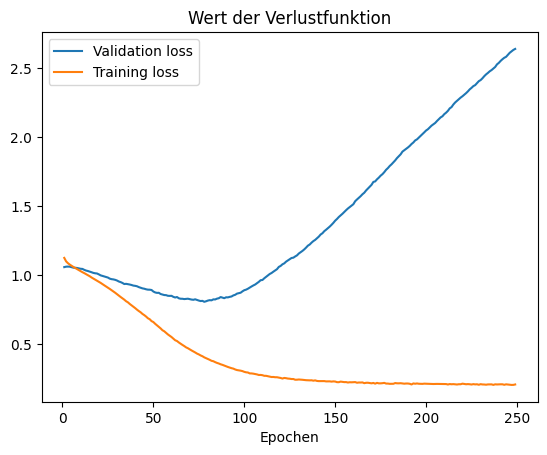

In [99]:
# k-cross-Validierung
avg_val_loss = [np.mean([x[i] for x in all_val_loss])
                    for i in range(num_epochs-1)]
avg_loss     = [np.mean([x[i] for x in all_loss])
                    for i in range(num_epochs-1)]
avg_acc      = [np.mean([x[i] for x in all_acc])
                    for i in range(num_epochs-1)]
avg_val_acc  = [np.mean([x[i] for x in all_val_acc])
                    for i in range(num_epochs-1)]

plt.plot(range(1, len(avg_val_loss) + 1), avg_val_loss, label = 'Validation loss')
plt.plot(range(1, len(avg_loss) + 1), avg_loss, label = 'Training loss')
plt.title('Wert der Verlustfunktion')
plt.xlabel('Epochen')
plt.legend()


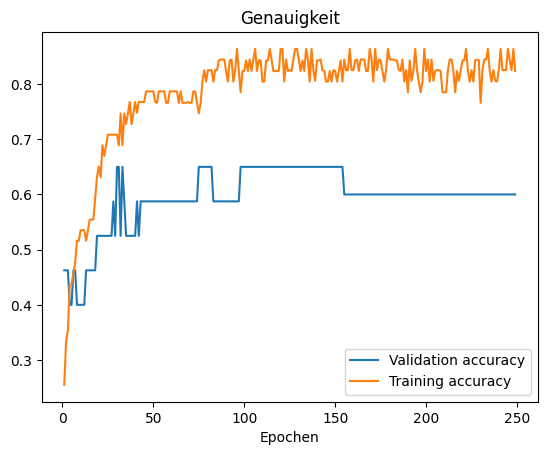

In [101]:
plt.plot(range(1, len(avg_val_acc) + 1), avg_val_acc, label = 'Validation accuracy')
plt.plot(range(1, len(avg_acc) + 1), avg_acc, label = 'Training accuracy')
plt.title('Genauigkeit')
plt.xlabel('Epochen')
plt.legend()


In [46]:
modelStatus = Sequential()
modelStatus.add(Dense(8, input_shape=(trainX.shape[1],), activation='relu'))
modelStatus.add(Dense(16, activation='relu'))
modelStatus.add(Dense(trainYStatus.shape[1], activation='softmax'))
modelStatus.summary()
modelStatus.compile(optimizer='rmsprop',
              loss=CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

historyStatus = modelStatus.fit(trainX, trainYStatus,
                    batch_size=2,
                    epochs=50,
                    verbose=2,
                    validation_split=0.25)

#modelStatement = Sequential()
#modelStatement.add(Dense(16, input_shape=(trainX.shape[1],), activation='relu'))
#modelStatement.add(Dense(8, activation='relu'))
#modelStatement.add(Dense(trainYStatement.shape[1], activation='softmax'))
#modelStatement.summary()
#modelStatement.compile(optimizer='adam',
#              loss=CategoricalCrossentropy(),
#              metrics=['accuracy'])
#
#historyStatement = modelStatement.fit(trainX, trainYStatement,
#                    batch_size=2,
#                    epochs=50,
#                    verbose=2,
#                    validation_split=0.4)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 8)                 1424      
                                                                 
 dense_37 (Dense)            (None, 16)                144       
                                                                 
 dense_38 (Dense)            (None, 3)                 51        
                                                                 
Total params: 1,619
Trainable params: 1,619
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
6/6 - 2s - loss: 1.0931 - categorical_accuracy: 0.3333 - val_loss: 1.0934 - val_categorical_accuracy: 0.4000 - 2s/epoch - 373ms/step
Epoch 2/50
6/6 - 0s - loss: 1.0761 - categorical_accuracy: 0.5000 - val_loss: 1.0859 - val_categorical_accuracy: 0.4000 - 63ms/epoch - 10ms/step
Epoch 3/50
6/6 - 0s - loss

In [ ]:
predictionStatus = modelStatus.predict(test)
col = 0
for i in predictionStatus:
    for j in i:
        print (trainYStatus.columns[col] + " " + '{:.1%}'.format(j))
        col += 1

print ("-----------------------------------------------------")

#predictionStatement = modelStatement.predict(test)
#index_max = np.argmax(predictionStatement)
#print (trainYStatement.columns[index_max] + " " + '{:.1%}'.format(predictionStatement[0][index_max]))
#col = 0
#for i in predictionStatement:
#    for j in i:
#        print (trainYStatement.columns[col] + " " + '{:.1%}'.format(j))
#        col += 1
#

In [ ]:
#Functional
inputs = Input(shape=trainX.shape[1])

hidden_layer = Dense(16, activation='relu')(inputs)

output1 = Dense(trainYStatus.shape[1], activation='softmax', name='status')(hidden_layer)

output2 = Dense(trainYStatement.shape[1], activation='softmax', name='statement')(hidden_layer)

model = Model(inputs=inputs, outputs=[output1, output2])

model.summary()

model.compile(optimizer='adam',
              loss={'status': CategoricalCrossentropy(), 'statement': CategoricalCrossentropy()},
              metrics=['accuracy'])

history = model.fit(trainX, {'status': trainYStatus, 'statement': trainYStatement},
                    batch_size=2,
                    epochs=50,
                    verbose=2,
                    validation_split=0.4)

In [ ]:
# Functional!
# Vorhersage machen
output_status, output_statement = model.predict(test)

# Ausgabe 1 vorhersagen
status_prediction = np.argmax(output_status)

# Ausgabe 2 vorhersagen
statement_prediction = np.argmax(output_statement)

for val in output_status:
    print (str(val))

#print("Status Probabilities:", output_status)
#print("Statement Prediction:", statement_prediction)

In [ ]:
# nur noch Infos --------------------------------------

In [ ]:
status = df['Status'].unique()
hauefigkeit = []
for x in status:
    hauefigkeit.append(len(df[df['Status'] == x]))
fig, ax = plt.subplots()
ax.pie(hauefigkeit, labels=status, autopct='%1.1f%%')

In [ ]:
print(df['RU'].unique())

In [ ]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

text = df['Text'].value_counts()
eins = 0
zwei = 0
drei = 0
vier = 0
for anzahl in text:
    if anzahl  < 5:                         # anzahl 0:4
        eins += 1
    if ((anzahl  >= 5) & (anzahl <= 9)):           # anzahl 5:9
        zwei += 1                           
    if ((anzahl  >= 10) & (anzahl <= 14)):           # anzahl 10:14
        drei += 1
    if anzahl  >= 15:                       # anzahl ab 15
        vier += 1
y = [eins, zwei, drei, vier]
x = ('0-4', '5-9', '10-14', 'ab 15')


plt.bar(x, y, align='center')
plt.xticks(x)
plt.title('Anzahl Anwendungsregeln nach Häufigkeit der Bewertung')
addlabels(x, y)
plt.show()

print ("Anzahl Anwendungsregeln, welche nur einmal bewertet wurden: " + str(eins))
print ("Anteil am Datensatz: " + str(round(round(eins/df.shape[0], 4) * 100, 2)) + "%")

In [ ]:
text = df['Text'].value_counts()
text.head()
test = df_training.loc[df_training['Text'] == "Zur Anschaltung des Antriebes in der Außenanlage müssen Signalkabel nach VDE 0816/2 oder Kabel mit vergleichbaren Eigenschaften verwendet werden. Die Verlegevorschriften des Kabels sind einzuhalten."]
test.reset_index(inplace=True, drop=True)
test.head(17)
#df['Text'].value_counts()

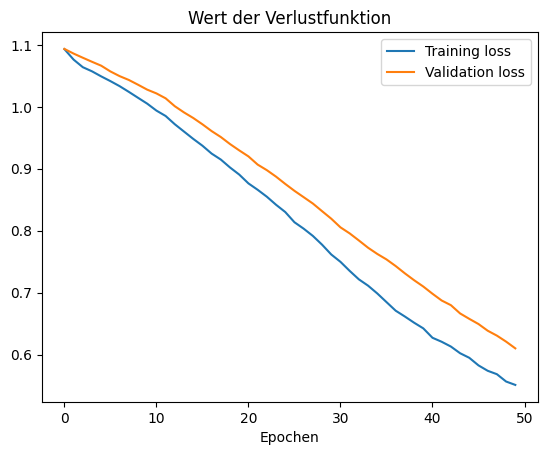

In [49]:
plt.plot(historyStatus.history['loss'], label = 'Training loss')
plt.plot(historyStatus.history['val_loss'], label = 'Validation loss')
plt.title('Wert der Verlustfunktion')
plt.xlabel('Epochen')
plt.legend()

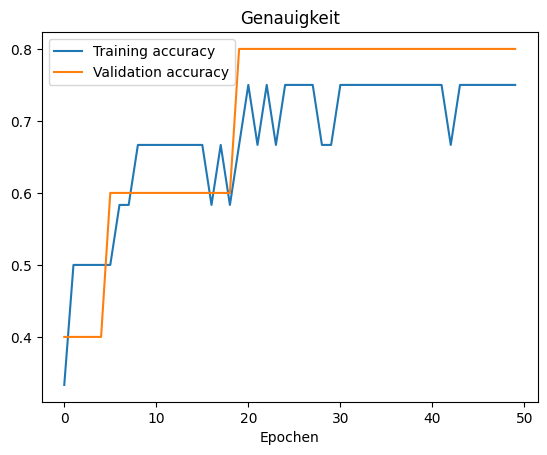

In [50]:
plt.plot(historyStatus.history['categorical_accuracy'], label = 'Training accuracy')
plt.plot(historyStatus.history['val_categorical_accuracy'], label = 'Validation accuracy')
plt.title('Genauigkeit')
plt.xlabel('Epochen')
plt.legend()